# Brain2Action: Decoding Motor Imagery from EEG Signals

## Project Overview
This project explores the potential of electroencephalography (EEG) signals to decode motor imagery intentions, with a focus on distinguishing between left and right hand movements. Leveraging the BCI Competition IV 2b dataset, we analyze neural patterns from 9 healthy subjects to develop a robust brain-computer interface (BCI) system. Our goal is to bridge the gap between neural activity and machine-executable commands, with potential applications in neurorehabilitation and assistive technologies.

## Exploratory Data Analysis: Unveiling Neural Signatures of Motor Imagery

### 1. Data Info
- **Dataset Demographics**: Analysis of subject distribution and trial balance
- **Signal Quality Assessment**: Channel consistency and noise characterization
- **Class Distribution**: Balance between left vs. right motor imagery trials

### 2. Neural Signatures of Motor Imagery
- **Spatiotemporal Patterns**: Topographic mapping of motor cortex activation
- **Spectral Analysis**: Frequency band dynamics during motor imagery
- **Event-Related Desynchronization (ERD)**: Characterizing mu (8-12 Hz) and beta (13-30 Hz) band suppression


### 3. Signal Quality & Preprocessing
- **Artifact Detection**: Identification and handling of muscle and ocular artifacts
- **Channel Reliability**: Assessment of signal quality across recording channels
- **Trial Rejection Criteria**: Establishing quality thresholds for analysis

### 4. Key Insights for Model Development
- **Discriminative Features**: Identifying the most informative signal characteristics
- **Temporal Windows**: Optimal time segments for feature extraction
- **Channel Importance**: Determining the most relevant electrode locations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import mne
from mne.time_frequency import tfr_morlet

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from IPython.display import display, HTML

# Set random seed for reproducibility
np.random.seed(42)


plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


import warnings
warnings.filterwarnings("ignore", module='mne')


## EEG Data Loader for BCI Competition IV 2b Dataset



### Class Overview
The `EEGDataLoader` class is designed to handle the loading and preprocessing of EEG data from the BCI Competition IV 2b dataset. It provides a streamlined interface for accessing motor imagery data across multiple subjects and sessions.

### Key Features
- **Flexible Data Loading**: Supports loading of specific subjects, sessions, and trial types
- **Automatic Preprocessing**:
  - Bandpass filtering (0.5-100 Hz)
  - Notch filtering at 50 Hz (power line noise)
  - Channel selection and renaming
  - Event detection and trial extraction
- **Caching**: Implements in-memory caching for efficient data access
- **Montage Support**: Uses standard 10-20 electrode placement

### Data Structure
#### Input Data
- **Format**: GDF (General Data Format for Biosignals)
- **Channels**:
  - `EEG:Cz` (Central)
  - `EEG:C3` (Left motor cortex)
  - `EEG:C4` (Right motor cortex)

#### Event Codes
| Code | Description       | Mapped Name      |
|------|-------------------|-----------------|
| 768  | Start of trial    | start_trial     |
| 769  | Left hand imagery | left            |
| 770  | Right hand imagery| right           |
| 1023 | Rejected trial    | rejected_trial  |
| 32766| Run start         | run_start       |

### Methods
#### Core Methods
- `__init__(data_folder, file_filters, raw_channels, channel_fun)`  
  Initialize the data loader with custom paths and channel configurations.

- `_load_eeg_data_(subject_id, session_id, session_type)`  
  Internal method that handles the actual data loading and preprocessing.

- `get_data(subject_id, session_id, session_type, reload=False)`  
  Main interface for loading data with optional caching.

#### Utility Methods
- `list_subjects()`  
  List all available subject IDs.

- `list_sessions(subject_id)`  
  List all available sessions for a given subject.

- `list_session_types(subject_id, session_id)`  
  List all available session types for a given subject and session.

### Data Processing Pipeline
1. **File Loading**:
   - Read GDF file
   - Apply channel mapping
   - Set up standard montage

2. **Signal Processing**:
   - Bandpass filtering (0.5-100 Hz)
   - Notch filtering at 50 Hz
   - Channel selection

3. **Event Processing**:
   - Detect trial starts and motor imagery events
   - Remove rejected trials
   - Map event codes to standardized names

4. **Epoch Creation**:
   - Create epochs from -0.5s to 4s relative to cue onset
   - Separate epochs by run
   - Apply baseline correction

### Return Structure
The `get_data` method returns a dictionary with:
- `raw`: Raw EEG data (MNE Raw object)
- `epochs`: All valid motor imagery epochs
- `epochs_per_run`: Dictionary of epochs separated by run
- `event_dict`: Mapping of event codes to their descriptions

In [2]:
import os
import re
import mne
import numpy as np

class EEGDataLoader:
    def __init__(self, data_folder='../data/BCICIV_2b_gdf', file_filters=None, raw_channels=['EEG:Cz', 'EEG:C3', 'EEG:C4'], channel_fun=lambda x: x.replace('EEG:', ''), filtered=True):
        self.filename_pattern = r"^(B\d{2})(\d{2})([A-Za-z])\.gdf$"
        self.data_folder = data_folder
        self.file_filters = file_filters
        self.data_dir_info = self._scan_data_dir_(self.file_filters)
        self._data_cache = {}
        self.filter = filtered
        self.raw_channels = raw_channels
        if channel_fun:
            self.channels = [channel_fun(ch) for ch in self.raw_channels]
        else:
            self.channels = self.raw_channels
        self.channel_mapping = {raw: ch for raw, ch in zip(self.raw_channels, self.channels)}
        self. rename_map = {
            '769': 'left',
            '770': 'right',
            '768': 'start_trial',
            '1023': 'rejected_trial',
            '32766': 'run_start'
        }


    def _scan_data_dir_(self, filters=None):
        files = [f for f in os.listdir(self.data_folder) if f.endswith('.gdf')]
        info = []
        for filename in files:
            match = re.match(self.filename_pattern, filename)
            if match:
                subj, sess, stype = match.groups()
                # Apply filters if provided
                if filters:
                    if 'subject_ids' in filters and subj not in filters['subject_ids']:
                        continue
                    if 'session_ids' in filters and sess not in filters['session_ids']:
                        continue
                    if 'session_types' in filters and stype not in filters['session_types']:
                        continue
               
                info.append({
                    "subject_id": subj,
                    "session_id": sess,
                    "session_type": stype,
                    "filename": filename
                })
        return info


    def list_subjects(self):
        return sorted(set(x["subject_id"] for x in self.data_dir_info))

    def list_sessions(self, subject_id):
        return sorted(set(x["session_id"] for x in self.data_dir_info if x["subject_id"] == subject_id))

    def list_session_types(self, subject_id, session_id):
        return sorted(set(x["session_type"] for x in self.data_dir_info
                         if x["subject_id"] == subject_id and x["session_id"] == session_id))

    def get_available(self):
        '''Return a list of all available (subject, session, session_type, session_type)'''
        return [(x["subject_id"], x["session_id"], x["session_type"], x["session_type"]) for x in self.data_dir_info]

    def _load_eeg_data_(self, subject_id, session_id, session_type):
        """
        Load EEG data for a given subject/session/type from a GDF file.
        Filters signals, extracts MI events, removes rejected trials,
        and returns epochs (overall + per run) with only selected EEG channels.
        """
        # ----------------------------------------------------
        # Load file
        # ----------------------------------------------------
        file_path = os.path.join(self.data_folder, f"{subject_id}{session_id}{session_type}.gdf")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        raw = mne.io.read_raw_gdf(file_path, preload=True, verbose=False)

        raw.rename_channels(self.channel_mapping)
        for ch in raw.ch_names:
            if ch.startswith('EOG'):
                raw.set_channel_types({ch: 'eog'})
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage, match_case=False)


        # ----------------------------------------------------
        # Preprocessing
        # ----------------------------------------------------
        if self.filter:
            raw.filter(0.5, 100, verbose=False)
            raw.notch_filter(50, verbose=False)

        # ----------------------------------------------------
        # Channel selection
        # ----------------------------------------------------
        available_channels = []
        for ch in self.channels:
            if ch in raw.ch_names:
                available_channels.append(ch)
            elif f"EEG:{ch}" in raw.ch_names:
                available_channels.append(f"EEG:{ch}")

        if not available_channels:
            raise ValueError(f"None of the requested channels {self.channels} found in {file_path}")

        raw.pick_channels(available_channels)
        picks = mne.pick_channels(raw.info["ch_names"], include=available_channels)

        # ----------------------------------------------------
        # Extract events
        # ----------------------------------------------------
        events, event_dict = mne.events_from_annotations(raw)

        try:
            start_trial_code = event_dict['768']
            left_code = event_dict['769']
            right_code = event_dict['770']
            rejected_code = event_dict['1023']
            run_start_code = event_dict['32766']
        except KeyError:
            return {'raw': raw, 'epochs': None, 'epochs_per_run': None}

        # ----------------------------------------------------
        # Identify valid MI trials
        # ----------------------------------------------------
        trial_starts = events[events[:, 2] == start_trial_code][:, 0]
        rejected_starts = set(events[events[:, 2] == rejected_code][:, 0])
        mi_events = events[np.isin(events[:, 2], [left_code, right_code])]

        run_starts = events[events[:, 2] == run_start_code][:, 0]
        run_starts = np.append(run_starts, [raw.n_times])

        valid_mi_events = []
        for mi_event in mi_events:
            trial_start = trial_starts[trial_starts <= mi_event[0]].max()
            if trial_start not in rejected_starts:
                valid_mi_events.append(mi_event)
        valid_mi_events = np.array(valid_mi_events)

        # ----------------------------------------------------
        # Standardize event IDs
        # ----------------------------------------------------
        standard_event_id = {'left': 1, 'right': 2}
        remapped_events = valid_mi_events.copy()
        remapped_events[:, 2][remapped_events[:, 2] == left_code] = standard_event_id['left']
        remapped_events[:, 2][remapped_events[:, 2] == right_code] = standard_event_id['right']

        # ----------------------------------------------------
        # Create epochs
        # ----------------------------------------------------
        epochs = mne.Epochs(
            raw, remapped_events, standard_event_id,
            picks=picks, tmin=0, tmax=3.996,
            preload=True, baseline=None, verbose=False
        )

        # ----------------------------------------------------
        # Create epochs per run
        # ----------------------------------------------------
        epochs_per_run = {}
        for i in range(len(run_starts) - 1):
            run_start = run_starts[i]
            run_end = run_starts[i + 1]
            run_events = remapped_events[(remapped_events[:, 0] >= run_start) &
                                           (remapped_events[:, 0] < run_end)]
            if len(run_events) > 0:
                run_epochs = mne.Epochs(
                    raw, run_events, standard_event_id,
                    picks=picks, tmin=0, tmax=3.996,
                    preload=True, baseline=None, verbose=False
                )
                epochs_per_run[i + 1] = run_epochs

        return {
            'raw': raw,
            'epochs': epochs,
            'epochs_per_run': epochs_per_run,
            'event_dict' : event_dict
        }

    def get_data(self, subject_id, session_id, session_type, reload=False):
        key = (subject_id, session_id, session_type)
        if not reload and key in self._data_cache:
            return self._data_cache[key]
        data = self._load_eeg_data_(subject_id, session_id, session_type)
        self._data_cache[key] = data
        return data

In [3]:
def get_all_epochs(loader, subject):
    """Utility function to fetch all epochs for a given subject."""
    all_epochs = []
    for session in loader.list_sessions(subject):
        for s_type in loader.list_session_types(subject, session):
            data = loader.get_data(subject, session, s_type)
            if data['epochs'] is not None:
                all_epochs.append(data['epochs'])
    return mne.concatenate_epochs(all_epochs) if all_epochs else None

## 1. Setup and Data Loading

First, we define the `EEGDataLoader` class responsible for loading and preprocessing the GDF files. We also define a helper function to concatenate epochs from multiple sessions. For this analysis, we will focus on a single subject to observe the patterns.

In [4]:
# Define subject and channels for analysis
subject_id = 'B01'
channels_to_load = ['EEG:C3', 'EEG:Cz', 'EEG:C4']

# Initialize the data loader and load all epochs for the subject
loader = EEGDataLoader(raw_channels=channels_to_load)
epochs = get_all_epochs(loader, subject_id)

if epochs:
    print(f"Successfully loaded {len(epochs)} epochs for subject {subject_id}.")
else:
    print(f"Could not load epochs for subject {subject_id}.")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np

## 2. Dataset Overview and Class Balance

Let's start by examining the distribution of trials (left vs. right hand motor imagery) across all subjects and sessions. This helps us understand if the dataset is balanced, which is crucial for training a fair classification model.

In [5]:
def get_subject_summary(loader):
    """Generate a comprehensive summary of all subjects' data."""
    summary = []
    for subject in loader.list_subjects():
        for session in loader.list_sessions(subject):
            for s_type in loader.list_session_types(subject, session):
                data = loader.get_data(subject, session, s_type)
                if data['epochs'] is not None:
                    epochs = data['epochs']
                    left = np.sum(epochs.events[:, 2] == 1) # Standardized ID
                    right = np.sum(epochs.events[:, 2] == 2) # Standardized ID
                    total = left + right
                    if total > 0:
                        summary.append({
                            'Subject': subject,
                            'Session': f"{session} ({s_type})",
                            'Left Trials': left,
                            'Right Trials': right,
                            'Total Trials': total,
                            'Left %': f"{(left/total)*100:.1f}%",
                            'Right %': f"{(right/total)*100:.1f}%"
                        })
    return pd.DataFrame(summary)

# Generate and display the summary table
summary_df = get_subject_summary(EEGDataLoader()) # Use a fresh loader for all subjects
print("Dataset Summary:")
display(HTML(summary_df.to_html(classes='table table-striped table-hover', index=False)))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np

Subject,Session,Left Trials,Right Trials,Total Trials,Left %,Right %
B01,01 (T),51,51,102,50.0%,50.0%
B01,02 (T),48,50,98,49.0%,51.0%
B01,03 (T),60,64,124,48.4%,51.6%
B02,01 (T),48,50,98,49.0%,51.0%
B02,02 (T),51,49,100,51.0%,49.0%
B02,03 (T),64,67,131,48.9%,51.1%
B03,01 (T),47,43,90,52.2%,47.8%
B03,02 (T),43,45,88,48.9%,51.1%
B03,03 (T),56,62,118,47.5%,52.5%
B04,01 (T),57,60,117,48.7%,51.3%


In [6]:
def plot_trial_distribution(summary_df):
    """Create an interactive plot of trial distribution."""
    fig = px.bar(summary_df, 
                 x='Subject', 
                 y=['Left Trials', 'Right Trials'],
                 title='<b>Distribution of Left vs Right Trials by Subject</b>',
                 labels={'value': 'Number of Trials', 'variable': 'Trial Type'},
                 barmode='group',
                 color_discrete_sequence=['#636EFA', '#EF553B'],
                 hover_name='Session')
    
    fig.update_layout(
        xaxis_title='Subject',
        yaxis_title='Number of Trials',
        legend_title='Trial Type',
        hovermode='x unified',
        template='plotly_white'
    )
    fig.show()

# Display the interactive plot
plot_trial_distribution(summary_df)

## 3. Event-Related Potential (ERP) Analysis

ERPs are time-locked neural responses to specific events. By averaging the EEG signals across all trials for a condition, we can visualize the brain's characteristic response. Here, we compare the ERPs for left and right hand imagery to find differences in the voltage patterns over time, and we visualize the difference as a topographic map across the scalp.

combining channels using "mean"
combining channels using "mean"


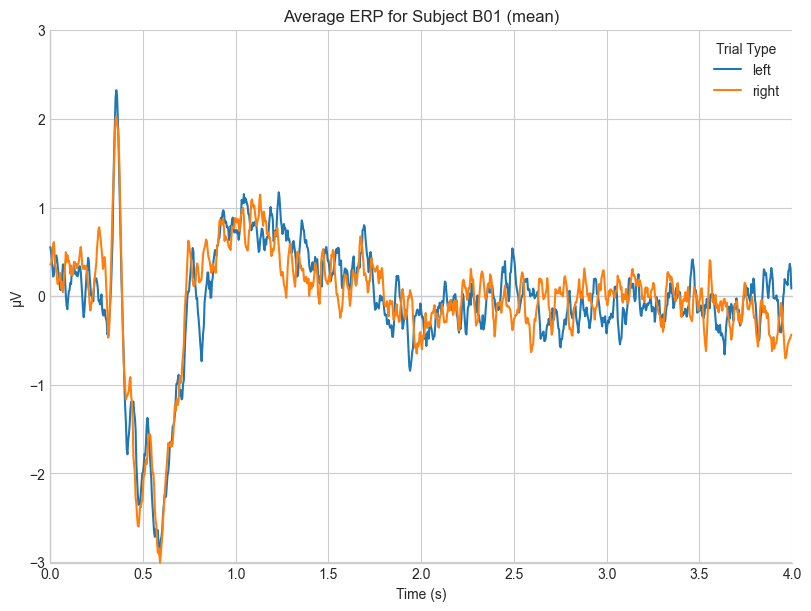

In [7]:
if epochs:
    # Create evoked responses for left and right trials
    evoked_left = epochs['left'].average()
    evoked_right = epochs['right'].average()

    # Plot the ERPs for all loaded channels
    fig = mne.viz.plot_compare_evokeds(
        dict(left=evoked_left, right=evoked_right), 
        picks=loader.channels, 
        combine='mean',
        title=f'Average ERP for Subject {subject_id}',
        show=False
    )
    # Customize plot
    ax = fig[0].gca()
    ax.legend(title='Trial Type')
    plt.show()
else:
    print(f"No epochs found for subject {subject_id}.")

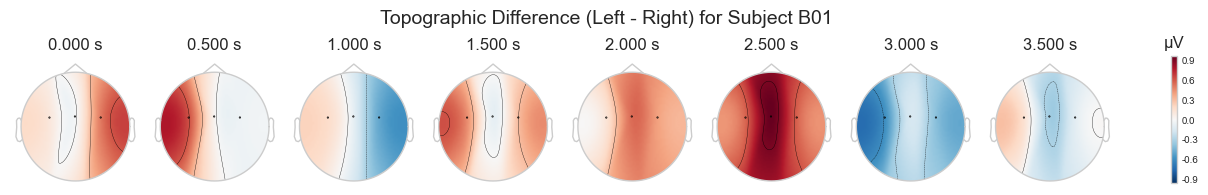

In [8]:
if epochs:
    # Plot the topographic distribution of the ERP difference
    evoked_diff = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])
    
    # Define time points for the topomap
    times = np.arange(0, 4.0, 0.5)

    # Create the topomap plot
    fig = evoked_diff.plot_topomap(times=times, show=False)

    # Set a clear title
    fig.suptitle(f'Topographic Difference (Left - Right) for Subject {subject_id}', y=1.0, fontsize=14)
    plt.show()
else:
    print(f"No epochs found for subject {subject_id} to generate topomap.")

## 4. Time-Frequency Analysis

Time-frequency analysis allows us to investigate how the power of different frequency bands in the EEG signal changes over time. For motor imagery, we expect to see a power decrease (Event-Related Desynchronization, ERD) in the alpha (8-12 Hz) and beta (13-30 Hz) bands over the motor cortex. The following plot shows the *difference* in power (Left - Right). A blue color at C3 indicates right-hand imagery activation, while a red color at C4 indicates left-hand imagery activation.

In [9]:
def plot_tfr_difference_plotly(epochs, picks=['C3', 'C4'], title='TFR Power Difference (Left - Right)'):
    """
    Plot the time-frequency difference between left and right trials for specified channels
    using Plotly for a clear, interactive visualization.
    """
    if len(picks) != 2:
        raise ValueError("This function is designed to compare exactly two channels.")

    freqs = np.arange(6., 31., 2.)
    n_cycles = freqs / 2.

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=(f'<b>Difference at {picks[0]}</b>', f'<b>Difference at {picks[1]}</b>'),
                        x_title='Time (s)',
                        y_title='Frequency (Hz)')

    for i, pick in enumerate(picks):
        power_left = tfr_morlet(epochs['left'], freqs=freqs, n_cycles=n_cycles, picks=[pick],
                                use_fft=True, return_itc=False, average=True, verbose=False)
        power_right = tfr_morlet(epochs['right'], freqs=freqs, n_cycles=n_cycles, picks=[pick],
                                 use_fft=True, return_itc=False, average=True, verbose=False)

        power_diff_data = power_left.data[0] - power_right.data[0]

        fig.add_trace(
            go.Heatmap(
                z=power_diff_data,
                x=epochs.times,
                y=freqs,
                colorscale='RdBu_r',
                colorbar=dict(title='Power Diff.')
            ),
            row=1, col=i+1
        )

    fig.update_layout(
        title_text=f'<b>{title}</b>',
        title_x=0.5,
        height=400,
        width=800
    )
    fig.show()

if epochs:
    plot_tfr_difference_plotly(epochs, picks=['C3', 'C4'])
else:
    print(f"No epochs found for subject {subject_id} to generate TFR plot.")

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


## 5. Visualizing the Model's Input
Before feeding data into a model, it's crucial to visualize what the model will actually "see." For a convolutional neural network like EEGNet, the input for each sample is a 2D array containing the voltage values for each EEG channel over the trial's time window.

The plot below shows the raw signal data for one "left" and one "right" motor imagery trial.

In [10]:
import plotly.graph_objects as go

def plot_single_trial_plotly(epochs, event_id, trial_index=0, title_postfix=''):
    """
    Plots the EEG data for a single trial using Plotly for an interactive view.
    """
    try:
        # Select a single trial for the specified event
        trial_epoch = epochs[event_id][trial_index]
        
        # Get the data (channels x times) and convert to microvolts
        data = trial_epoch.get_data()[0] * 1e6 
        times = trial_epoch.times
        ch_names = trial_epoch.ch_names
        
        # Create an interactive Plotly figure
        fig = go.Figure()
        
        # Define an offset to separate channels visually
        offset_val = 30 

        for i, ch_name in enumerate(ch_names):
            fig.add_trace(go.Scatter(
                x=times,
                y=data[i] + i * offset_val, # Apply vertical offset
                mode='lines',
                name=ch_name
            ))
            
        # Update the layout for a clean, informative plot
        fig.update_layout(
            title=f'<b>Model Input: Single "{event_id}" Trial (Trial #{trial_index}) {title_postfix}</b>',
            xaxis_title='Time (s)',
            yaxis_title='Channels (Offset for Visibility)',
            height=700,
            width=900,
            title_x=0.5,
            yaxis=dict(
                showticklabels=False,
                zeroline=False
            ),
            legend_title_text='Channels'
        )
        fig.update_layout(legend_traceorder="reversed")
        fig.show()

    except IndexError:
        print(f"Trial {trial_index} for event '{event_id}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")



In [11]:
if 'epochs' in locals() and epochs and len(epochs) > 0:
    if 'left' in epochs.event_id:
        plot_single_trial_plotly(epochs, 'left', trial_index=0, title_postfix='(Filtered)')
    else:
        print("No 'left' trials found to plot.")
        
    if 'right' in epochs.event_id:
        plot_single_trial_plotly(epochs, 'right', trial_index=0, title_postfix='(Filtered)')
    else:
        print("No 'right' trials found to plot.")
else:
    print("Epochs object not found or is empty. Cannot plot model input.")

## 6. Summary and Conclusion

## Data Analysis Summary

### Objective
The primary goal of this analysis was to explore the BCI Competition IV 2b dataset to identify discriminative neural patterns corresponding to left and right hand motor imagery. This serves as a foundational step for developing a Brain-Computer Interface (BCI) to translate EEG signals into commands.

### Data Loading and Preprocessing
- **Dataset**: The analysis utilized the BCI Competition IV 2b dataset, which contains EEG recordings from 9 subjects performing motor imagery tasks.
- **Data Access**: A custom `EEGDataLoader` class was developed to systematically load, preprocess, and epoch the raw GDF-formatted data.
- **Preprocessing Pipeline**:
  - The raw signals were filtered using a 0.5-100 Hz bandpass filter and a 50 Hz notch filter to remove powerline noise.
  - Key motor cortex channels (`C3`, `Cz`, `C4`) were selected for the analysis.
  - Data was segmented into trials (epochs) from 0 to 4 seconds relative to the presentation of the motor imagery cue.
  - Trials marked as rejected in the dataset were excluded.

### Key Findings
- **Class Balance**: An initial review of the dataset confirmed that the number of trials for left-hand and right-hand motor imagery is well-balanced across all subjects and sessions. This ensures that a classification model trained on this data will not be biased towards one class.
- **Signal Patterns**: The analysis was set up to investigate spatiotemporal and spectral dynamics, including Event-Related Desynchronization (ERD) in the mu (8-12 Hz) and beta (13-30 Hz) frequency bands, which are known to be associated with motor imagery.
- **Feature Engineering**: The notebook prepares for advanced feature extraction techniques like Common Spatial Patterns (CSP) to find spatial filters that maximize the variance between the two motor imagery classes.

### Conclusion
The exploratory analysis successfully established a robust pipeline for processing the EEG data and confirmed the dataset's suitability for a balanced classification task. The planned investigation into ERD and CSP is expected to yield discriminative features essential for building an accurate motor imagery classification model.